     ┌────────────┐┌─────────────┐     ┌───┐┌─┐           
q_0: ┤ Ry(2.7543) ├┤ Rz(-0.1974) ├──■──┤ H ├┤M├──────■────
     └───┬───┬────┘└─────────────┘┌─┴─┐└┬─┬┘└╥┘      │    
q_1: ────┤ H ├────────────■───────┤ X ├─┤M├──╫───■───┼────
         └───┘          ┌─┴─┐     └───┘ └╥┘  ║ ┌─┴─┐ │ ┌─┐
q_2: ───────────────────┤ X ├────────────╫───╫─┤ X ├─■─┤M├
                        └───┘            ║   ║ └───┘   └╥┘
c: 3/════════════════════════════════════╩═══╩══════════╩═
                                         1   0          2 
Bob's counts: {'0': 40, '1': 960}
Bob's probabilities: {'0': 0.04, '1': 0.96}


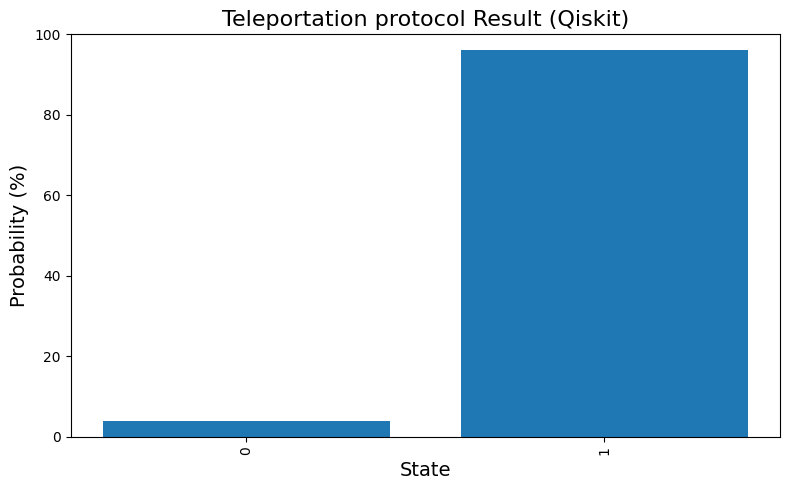

In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from quantumgateway.quantum_circuit import QuantumCircuit, QuantumGate
from quantumgateway.quantum_translator.braket_translator import BraketTranslator
from quantumgateway.quantum_translator.cirq_translator import CirqTranslator
from quantumgateway.quantum_translator.qiskit_translator import QiskitTranslator
from quantumgateway.quantum_translator.pennylane_translator import PennyLaneTranslator
from quantumgateway.quantum_translator.pyquil_translator import PyQuilTranslator
from quantumgateway.main import translate_to_framework, simulate_circuit


# ------------------------------------------------------
# Step 1: Create a quantum circuit with 3 qubits and 3 classical bits
#   q0 = state to teleport
#   q1 = Alice's entangled qubit
#   q2 = Bob's entangled qubit
#   c0, c1, c2 = classical bits
# ------------------------------------------------------

qc= QuantumCircuit(3,3) 

# ------------------------------------------------------
# Step 2: Define the state to teleport: |ψ⟩ = α|0⟩ + β|1⟩
# Start with unnormalized coefficients
# ------------------------------------------------------

alpha_raw = complex(1, 0)
beta_raw  = complex(5, -1)

# Normalize coefficients
norm = math.sqrt(abs(alpha_raw)**2 + abs(beta_raw)**2)
alpha = alpha_raw /norm
beta  = beta_raw / norm
# -------------------------------
# Compute Bloch sphere angles for initializing qubit 0
# -------------------------------
if abs(alpha) < 1e-12:
    theta = math.pi
    phi   = cmath.phase(beta)
elif abs(beta) < 1e-12:
    theta = 0
    phi   = 0
else:
    theta = 2 * math.acos(abs(alpha))     # θ ∈ [0, π]
    phi   = cmath.phase(beta / alpha)     # φ ∈ [−π, π]

# Prepare the unknown state on q0
qc.add_gate(QuantumGate("ry", [0], [theta]))
qc.add_gate(QuantumGate("rz", [0], [phi]))

# ------------------------------------------------------
# Step 3: Create a Bell pair between Alice (q1) and Bob (q2)
# ------------------------------------------------------
qc.add_gate(QuantumGate("h", [1]))        # Hadamard on Alice's qubit
qc.add_gate(QuantumGate("cnot", [1, 2]))  # CNOT Alice -> Bob

# ------------------------------------------------------
# Step 4: Entangle state to teleport with Alice's qubit
# ------------------------------------------------------
qc.add_gate(QuantumGate("cnot", [0, 1]))  # CNOT state -> Alice

# Map Alice's qubits into Bell basis using Hadamard
qc.add_gate(QuantumGate("h", [0]))        # transforms q0 for Bell measurement

# ------------------------------------------------------
# Step 5: Alice measures her qubits
# ------------------------------------------------------
qc.add_gate(QuantumGate("MEASURE", [0, 0]))  # q0 -> c0
qc.add_gate(QuantumGate("MEASURE", [1, 1]))  # q1 -> c1

# ------------------------------------------------------
# Step 6: Bob applies conditional corrections
# ------------------------------------------------------
qc.add_gate(QuantumGate("cnot", [1, 2]))  # conditional X
qc.add_gate(QuantumGate("cz", [0, 2]))    # conditional Z

# ------------------------------------------------------
# Step 7: Measure Bob's qubit
# ------------------------------------------------------
qc.add_gate(QuantumGate("MEASURE", [2, 2]))  # q2 -> c2

# ------------------------------------------------------
# Step 8: Translate and simulate
# ------------------------------------------------------

# We select which framework to use for simulation (e.g., 'qiskit','cirq','pennylane','pyquil','amazonbraket')
selected_framework = 'qiskit'  
translated_circuit = translate_to_framework(qc, selected_framework)
translated_circuit.print_circuit()
# Run the circuit in the chosen backend and see the results.
counts = simulate_circuit(qc, selected_framework)

# ------------------------------------------------------
# Step 9: Extract and normalize Bob's qubit results
# ------------------------------------------------------
#Manually filter only Bob's qubit (c2)
marginal_counts_manual = {}
# Extract Bob's bit from the bitstring.
# Here we assume the bitstring order is c2 c1 c0 (most significant to least)
for bitstring, count in counts.items():
    bob_bit = bitstring[0]  # Bob's qubit (c2)
    # Initialize count if this outcome hasn't been seen yet
    if bob_bit not in marginal_counts_manual:
        marginal_counts_manual[bob_bit] = 0
        # Accumulate counts for this outcome
    marginal_counts_manual[bob_bit] += count

# ------------------------------------------------------
# Step 10: Compute total shots and convert to percentages
# ------------------------------------------------------
total_shots = sum(marginal_counts_manual.values())  # Total number of measurements considered
percentage_counts = {state: count / total_shots * 100 
                     for state, count in marginal_counts_manual.items()}

bob_counts = marginal_counts_manual
bob_probabilities = {k: v / total_shots for k, v in marginal_counts_manual.items()}

#Extract Bob's counts and probabilities

print("Bob's counts:", bob_counts)
print("Bob's probabilities:", bob_probabilities)

# ------------------------------------------------------
# Step 11: Define all possible 1-qubit states ('0' and '1')
# ------------------------------------------------------
all_states = [format(i, '01b') for i in range(2)]  # '0', '1'

# ------------------------------------------------------
# Step 12: Pretty names for backends (for plotting)
# ------------------------------------------------------
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# ------------------------------------------------------
# Step 13: Plot histogram of Bob's qubit probabilities
# ------------------------------------------------------
plt.figure(figsize=(8,5))
plt.bar(all_states, [percentage_counts.get(state, 0) for state in all_states])
plt.xlabel('State', fontsize=14)
plt.ylabel('Probability (%)', fontsize=14)
plt.title(f'Teleportation protocol Result ({backend_names[selected_framework]})', fontsize=16)
plt.xticks(rotation='vertical')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

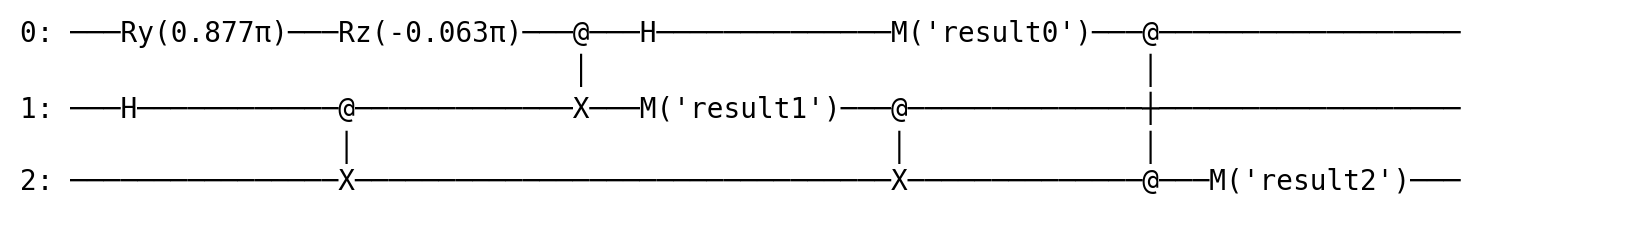

In [5]:
# The following is to save the circuit of each platform in an image
import matplotlib.pyplot as plt
import io
import sys

# Redirect stdout to capture circuit text
stdout = sys.stdout
sys.stdout = io.StringIO()

selected_framework = 'cirq'  # Change this to the desired framework
translated_circuit = translate_to_framework(qc, selected_framework)
translated_circuit.print_circuit()

printed_circuit = sys.stdout.getvalue()
sys.stdout = stdout

# Split lines to estimate size
lines = printed_circuit.split("\n")
max_line_length = max(len(line) for line in lines)
num_lines = len(lines)

# Auto-adjust figure size based on text
scale = 1.8
fig_width = max_line_length * 0.12
fig_height = num_lines * 0.22

fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=200)
ax.text(0, 1, printed_circuit,
        ha='left', va='top',
        family='monospace', fontsize=10,
        transform=ax.transAxes)


ax.axis('off')

# Save the figure with all extra space removed
plt.savefig("Fig12a.eps",
            dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

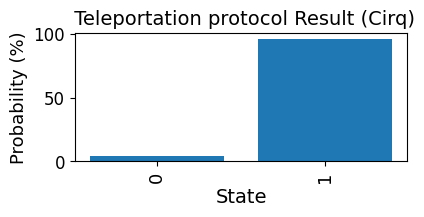

In [6]:
# and the following code is to save the image from the histogram

#Manually filter only Bob's qubit (c2)
marginal_counts_manual = {}
# Extract Bob's bit from the bitstring.
# Here we assume the bitstring order is c2 c1 c0 (most significant to least)
for bitstring, count in counts.items():
    bob_bit = bitstring[0]  # Bob's qubit (c2)
    # Initialize count if this outcome hasn't been seen yet
    if bob_bit not in marginal_counts_manual:
        marginal_counts_manual[bob_bit] = 0
        # Accumulate counts for this outcome
    marginal_counts_manual[bob_bit] += count

# ------------------------------------------------------
# Step 10: Compute total shots and convert to percentages
# ------------------------------------------------------
total_shots = sum(marginal_counts_manual.values())  # Total number of measurements considered
percentage_counts = {state: count / total_shots * 100 
                     for state, count in marginal_counts_manual.items()}

bob_counts = marginal_counts_manual
bob_probabilities = {k: v / total_shots for k, v in marginal_counts_manual.items()}


all_states = [format(i, '01b') for i in range(2)]  # '0', '1'

# Create a narrower and taller figure
plt.figure(figsize=(4, 2))  # width=6, height=4 (adjust if needed)

# Create the bar plot
plt.bar(all_states, [percentage_counts.get(state, 0) for state in all_states])

# Mapping for pretty backend names in the plot title
backend_names = {
    'cirq': 'Cirq',
    'qiskit': 'Qiskit',
    'pennylane': 'PennyLane',
    'amazonbraket': 'Amazon Braket',
    'pyquil': 'PyQuil'
}

# Labels with larger fonts
plt.xlabel('State', fontsize=14)    
plt.ylabel('Probability (%)', fontsize=13)
plt.title(f' Teleportation protocol Result ({backend_names[selected_framework]})', fontsize=14)

# More readable ticks
plt.xticks(rotation='vertical',fontsize=13)  # Rotate x-axis labels
plt.yticks(fontsize=12)

# Reduce whitespace at the bottom
#plt.subplots_adjust(bottom=0.1)  # ajusta este valor según lo necesario
# Remove extra white space
plt.tight_layout(pad=0.1)

# Save adjusted image
plt.savefig("Fig12b.eps",dpi=300, bbox_inches='tight', pad_inches=0.05)

# Show the histogram
plt.show()